# Enhancing Security: Facial comparison for Student ID Verification
---
This is the google colab that performs the following:

*   Step 1: Load dataset and train it using Siamese Networks
*   Step 2: Take a picture using a webcam as one input
*   Step 3: Scan a student ID to get an ID number
*   Step 4: Use the ID number to locate a profile image from the database
*   Step 5: Compare the 2 images and produce the disimilarity score


# Imports and Installations

tesseract-ocr and pytesseract installation

In [3]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


Import neccesary libraries

In [4]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random

import torch
from torch.autograd import Variable
import PIL.ImageOps
from PIL import Image
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import cv2
from torchvision.utils import make_grid

from IPython.display import display, Javascript
from IPython.display import Image as JSImage
from google.colab.output import eval_js
from base64 import b64decode, b64encode

import io
import html
import time
import pytesseract
import shutil
import os

## Helper functions
Function to displays image and plot graphs

In [5]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

##Mounting your google drive directory here

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd '/content/gdrive/My Drive/ITCS 4152 Comp Vis/Comp vis project/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master'

/content/gdrive/My Drive/ITCS 4152 Comp Vis/Comp vis project/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master


In [7]:
%cd '/content/gdrive/My Drive/Comp vis project/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master'

/content/gdrive/.shortcut-targets-by-id/1NsuWhgT7wyB3WvvZpE1626o2DZWE1090/Comp vis project/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master


## Configuration Class
A simple class to manage configuration

In [8]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64*4
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [9]:
class SiameseNetworkDataset(Dataset):

    def __init__(self, imageFolderDataset, transform=None, should_invert=True, augmentations=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert
        self.augmentations = augmentations

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found

                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        # Apply data augmentations
        if self.augmentations is not None:
            img0 = self.augmentations(img0)
            img1 = self.augmentations(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [10]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)

Apply augmentations

In [11]:
randomColors = transforms.Compose([transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3)])
randomRotation = transforms.Compose([transforms.RandomRotation(degrees=10),])
randomHorizontalFlip = transforms.Compose([transforms.RandomHorizontalFlip()])

siamese_dataset = SiameseNetworkDataset(
    imageFolderDataset=folder_dataset,
    transform=transforms.Compose([transforms.Resize((100,100)),
    transforms.ToTensor(),
    ]),
    should_invert=False,
)

siamese_dataset_randomColors = SiameseNetworkDataset(
    imageFolderDataset=folder_dataset,
    transform=transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor()
    ]),
    should_invert=False,
    augmentations=randomColors
)

siamese_dataset_randomHorizontalFlip = SiameseNetworkDataset(
    imageFolderDataset=folder_dataset,
    transform=transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor()
    ]),
    should_invert=False,
    augmentations=randomHorizontalFlip
)

siamese_dataset_randomRotation= SiameseNetworkDataset(
    imageFolderDataset=folder_dataset,
    transform=transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor()
    ]),
    should_invert=False,
    augmentations=randomRotation
)

In [12]:
combined_dataset = ConcatDataset([siamese_dataset, siamese_dataset_randomColors, siamese_dataset_randomRotation, siamese_dataset_randomHorizontalFlip])
print(len(combined_dataset))

1480


In [13]:
siamese_dataset_test = SiameseNetworkDataset(
    imageFolderDataset=folder_dataset_test,
    transform=transforms.Compose([transforms.Resize((100,100)),
    transforms.ToTensor(),
    ]),
    should_invert=False,
)
print(len(siamese_dataset_test))

30


## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


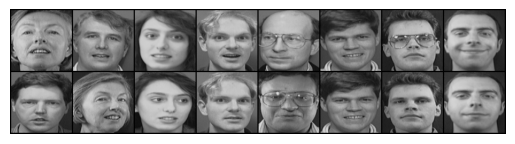

[[1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [14]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition

Custom stanrdard convolutional network model

In [36]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(16*12*12, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5),
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

use vgg instead

In [16]:
import torch.nn as nn
import torchvision.models as models

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Use pre-trained VGG16 as the base model
        self.vgg16 = models.vgg16(pretrained=True)

        # Modify the first convolutional layer to accept one channel
        self.vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)

        # Modify the fully connected layers to match your output size
        in_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Sequential(
            nn.Linear(in_features, 500),
            nn.Linear(500, 5)
        )

    def forward_once(self, x):
        output = self.vgg16(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [37]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [38]:
train_dataloader = DataLoader(combined_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)
val_dataloader = DataLoader(siamese_dataset_test,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


There seems to be a problem when using GPU. Run the second block of code if you are asked to purchase GPU blocks or "Found no NVIDIA driver on your system" error. Otherwise, run the first block of code and skip the second block

In [40]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [41]:
counter = []
a = 0
loss_history = []
val_loss_history = []
acc_history = []
iteration_number= 0

Epoch number 0
Current training loss 1.5128505229949951
Validation Loss: 1.1312516927719116
Validation Accuracy: 0.6333333333333333

Epoch number 1
Current training loss 0.9547771215438843
Validation Loss: 1.2630314826965332
Validation Accuracy: 0.7333333333333333

Epoch number 2
Current training loss 0.7069138288497925
Validation Loss: 1.2865828275680542
Validation Accuracy: 0.8666666666666667

Epoch number 3
Current training loss 0.5343267917633057
Validation Loss: 1.5224426984786987
Validation Accuracy: 0.9

Epoch number 4
Current training loss 0.5012266039848328
Validation Loss: 1.1378456354141235
Validation Accuracy: 0.9666666666666667

Epoch number 5
Current training loss 0.5216854810714722
Validation Loss: 1.4775334596633911
Validation Accuracy: 0.9

Epoch number 6
Current training loss 0.4512742757797241
Validation Loss: 1.3868077993392944
Validation Accuracy: 0.9666666666666667

Epoch number 7
Current training loss 0.4264354705810547
Validation Loss: 1.3400228023529053
Validat

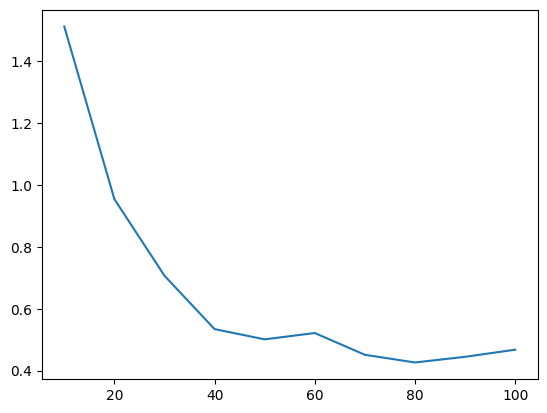

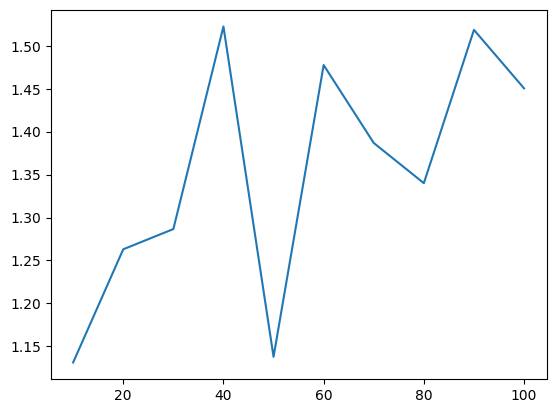

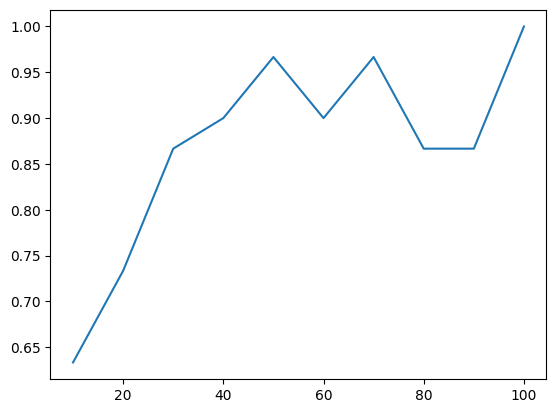

In [42]:
for epoch in range(0, Config.train_number_epochs):
    for i, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"Epoch number {epoch}")
            print(f"Current training loss {loss_contrastive.item()}")
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

    # Validation and accuracy after each epoch
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        threshold = 0.9
        for val_data in val_dataloader:
            val_img0, val_img1, val_label = val_data
            val_img0, val_img1, val_label = val_img0.cuda(), val_img1.cuda(), val_label.cuda()
            val_output1, val_output2 = net(val_img0, val_img1)

            distances = F.pairwise_distance(val_output1, val_output2)
            predictions = (distances > threshold).float()
            predictions = predictions.long()
            val_label = val_label.view(-1).long()
            correct += torch.sum(predictions == val_label).item()
            total += val_label.size(0)

            val_loss += criterion(val_output1, val_output2, val_label).item()

        val_loss /= len(val_dataloader)
        val_loss_history.append(val_loss)

        accuracy = correct / total
        acc_history.append(accuracy)
        print(f"Validation Loss: {val_loss}")
        print(f"Validation Accuracy: {accuracy}\n")
        if(accuracy >= .96):
          a += 1
          if(a >= 3):
            break

# Correct indentation for show_plot calls
show_plot(counter, loss_history)
show_plot(counter, val_loss_history)
show_plot(counter, acc_history)

# Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

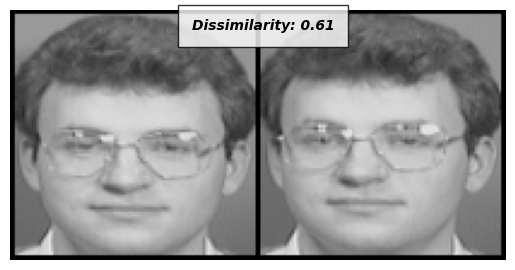

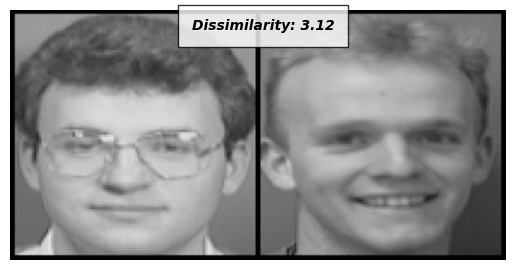

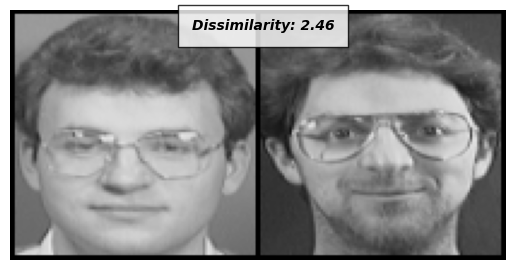

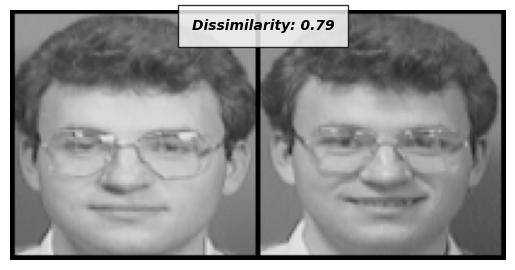

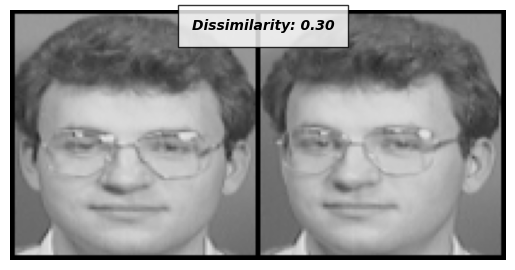

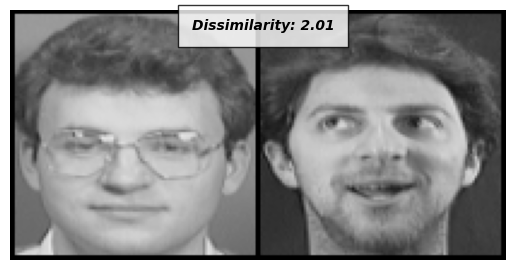

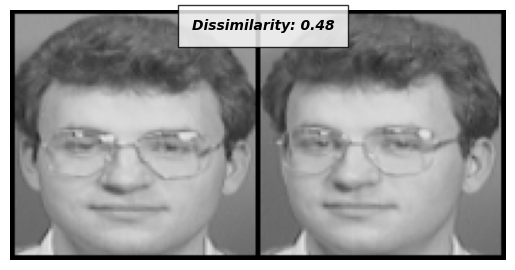

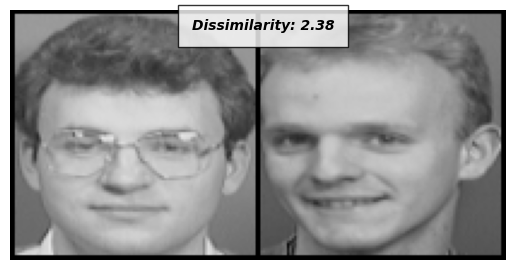

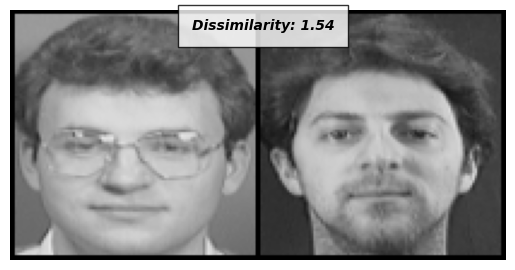

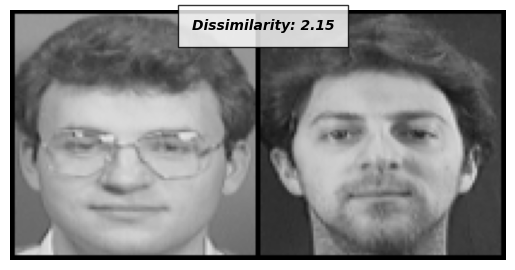

In [45]:
#the testing code :
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)

    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

# Passing in our own images

Invoke camera to take picture

In [23]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [24]:
def take_photo(filename='photo.jpg', quality=0.8, flip=False, rotate=False):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';

      const devices = await navigator.mediaDevices.enumerateDevices();
      console.log('Available video devices:', devices);

      //const stream = await navigator.mediaDevices.getUserMedia({video: true});
      const stream = await navigator.mediaDevices.getUserMedia({video: {
        deviceId: "aed8266c6a448710f819ee8d6599b70e9cfc1ff8651d6fbca77f215e1801f344",
}});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      div.style.width = document.documentElement.scrollHeight + 'px';
      div.style.height = document.documentElement.scrollWidth + 'px';
      div.style.transform = 'rotate(90deg)';

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  #rotate image
  if rotate == True:
    img=cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  #flip image
  if flip == True:
    img = cv2.flip(img, 1)

  cv2.imwrite(filename, img)

  return filename

##DEMO

<IPython.core.display.Javascript object>

Saved to photo.jpg


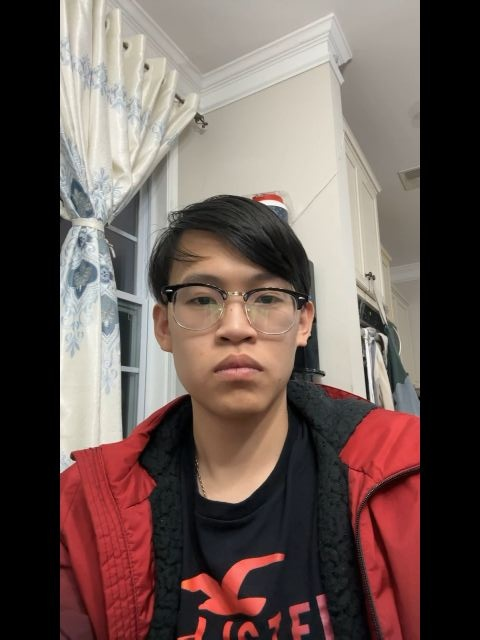

In [46]:
try:
  filename = take_photo('photo.jpg', flip=False, rotate=True)
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(JSImage(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Extract student ID from our id

<IPython.core.display.Javascript object>

Saved to studentId.jpg


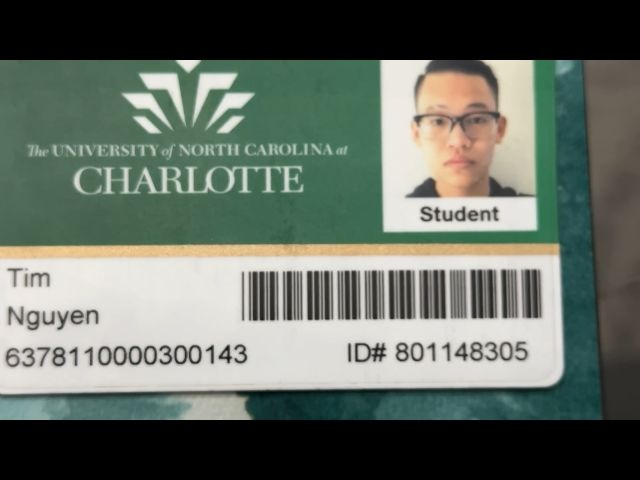

In [47]:
try:
  filename = take_photo('studentId.jpg', flip=False)
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(JSImage(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


Otsu's Threshold Value: 135.0


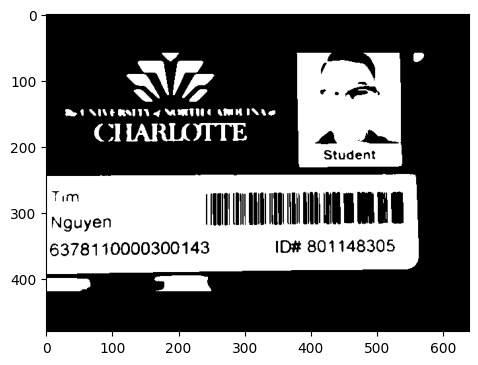

In [48]:
# Read and preprocess the image
image = cv2.imread('studentId.jpg')
image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:, :, 2]
kernel = np.ones((1, 1), np.uint8)
image = cv2.dilate(gray, kernel, iterations=1)
_, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("Otsu's Threshold Value:", _)

# Set the figure size before plotting
plt.figure(figsize=(12, 6))  # Adjust the width and height as needed

# Plot the image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

# Show the plot
plt.show()

In [49]:
extractedInformation = pytesseract.image_to_string(thresh)
import re

def extract_id(input_string):
    # Define a regular expression pattern to match the ID
    pattern = r'ID# (\d{9})'

    # Use re.search to find the match in the input string
    match = re.search(pattern, input_string)

    # Check if a match is found
    if match:
        # Extract the ID from the match
        id_number = match.group(1)
        return id_number
    else:
        return None
print('raw extraction: ', extractedInformation)
result = extract_id(extractedInformation)
print("result:", result)

while True:
    # Check if the file does not exist in the database
    if len(extractedInformation) == 0 or cv2.imread("./database/{}.png".format(result)) is None:
        print("Your data was not found. Please enter your ID manually.")
        # Set a custom value when the file doesn't exist in the database
        result = input("Enter Student ID: ")
    else:
        break  # Exit the loop if the condition is met

raw extraction:  RG

ca ay Vi. Cake

Student

Neuen OAC 0 WO

 

6378110000300143 ID# 801148305

 

result: 801148305


# The below cell is to test out if we can crop around the face.


Crop images

< cv2.CascadeClassifier 0x7ced94159bd0>
(640, 480) 0 254
(200, 200) 0 255
Number of detected faces in img1: 1


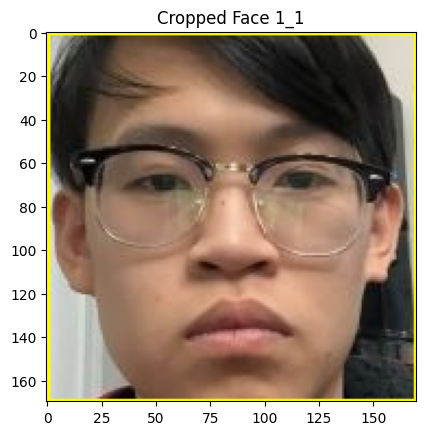

Number of detected faces in img2: 1


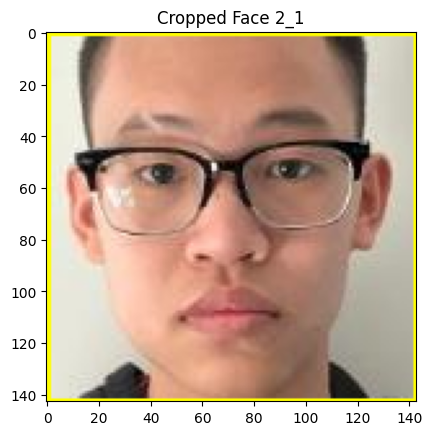

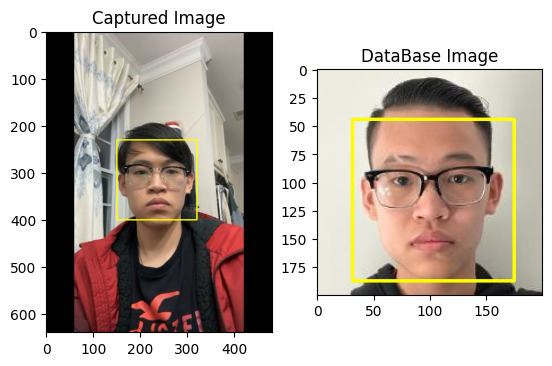

In [50]:
#link to crop out faces: https://www.tutorialspoint.com/how-to-crop-and-save-the-detected-faces-in-opencv-python
img1 = cv2.imread('./photo.jpg')
img2 = cv2.imread("./database/{}.png".format(result))

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

print(face_cascade) # print classifier
print(gray1.shape, gray1.min(), gray1.max()) # print image stats
print(gray2.shape, gray2.min(), gray2.max()) # print image stats

faces = []
cropped_faces = []

for i in range(2):
  faces.append(face_cascade.detectMultiScale(gray1 if i == 0 else gray2, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)))

for i, face_list in enumerate(faces):
    print(f'Number of detected faces in img{i + 1}:', len(face_list))

    # loop over all detected faces
    for j, (x, y, w, h) in enumerate(face_list):

        # To draw a rectangle in a face
        cv2.rectangle(img1 if i == 0 else img2, (x, y), (x+w, y+h), (0, 255, 255), 2)

        # Crop the face
        face = img1[y:y+h, x:x+w] if i == 0 else img2[y:y+h, x:x+w]
        cropped_faces.append(face)

        # Display the cropped face
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        plt.title(f'Cropped Face {i + 1}_{j + 1}')
        plt.show()

# Display the images with detected faces
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Captured Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('DataBase Image')

plt.show()

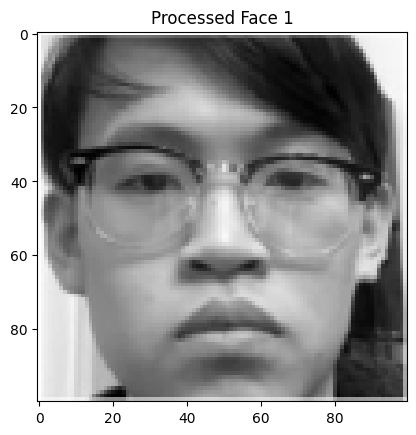

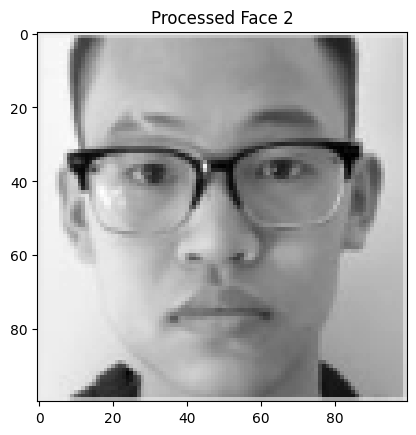

In [51]:
# Assuming cropped_faces is a list of cropped face images (NumPy arrays)
cropped_faces_pil = [Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB)) for face in cropped_faces]

# Resize and convert to grayscale using the defined transformation
preprocess = transforms.Compose([transforms.Resize((100, 100)),
                                 transforms.Grayscale(),
                                 transforms.ToTensor()])

# Unsqueezing and applying the transformation
final_tensors = [preprocess(face).unsqueeze(0) for face in cropped_faces_pil]

# Display the processed images
for i, final_tensor in enumerate(final_tensors):
    plt.imshow(final_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f'Processed Face {i + 1}')
    plt.show()

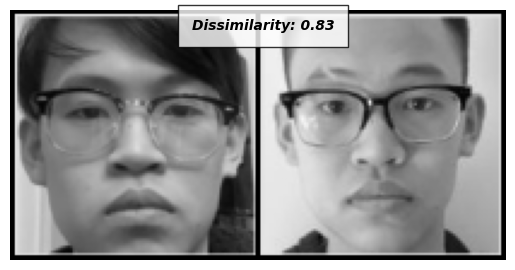

In [55]:
output1, output2 = net(Variable(final_tensors[0]).cuda(), Variable(final_tensors[1]).cuda())
# output1, output2 = net(Variable(final_tensors[0]), Variable(final_tensors[1]))

euclidean_distance = F.pairwise_distance(output1, output2)
# Display the results
concatenated = torch.cat((final_tensors[0], final_tensors[1]), 0)
imshow(make_grid(concatenated), 'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
# Define the imshow function
def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()